In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from model import TrainMgr
from utils import *

In [2]:
with open('MAPS_logmel229/train.p', 'rb') as f:
    [x_list, y_list, na_list] = pickle.load(f, encoding='latin-1')
# x_list: [(N1, 229), (N2, 229), ...]
# y_list: [(N1, 88), (N2, 88), ...]
# na_list: list of names. 

# Split train vs test
x_list_train, x_list_test, y_list_train, y_list_test = train_test_split(x_list, y_list, test_size=0.2)

# Create stacked data frames
n_channels = 3
X_train, y_train = make_multi_channel(x_list_train, y_list_train, n_channels)
X_test, y_test = make_multi_channel(x_list_test, y_list_test, n_channels)

# Normalize
scaler = StandardScaler()
scaler.fit(X_train[:, 0, :])
for i in range(n_channels):
    X_train[:, i, :] = scaler.transform(X_train[:, i, :])
    X_test[:, i, :] = scaler.transform(X_test[:, i, :])
    
# Cast to torch
dataset_train = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

y_list_train_torch = [torch.FloatTensor(y) for y in y_list_train]
y_list_test_torch = [torch.FloatTensor(y) for y in y_list_test]

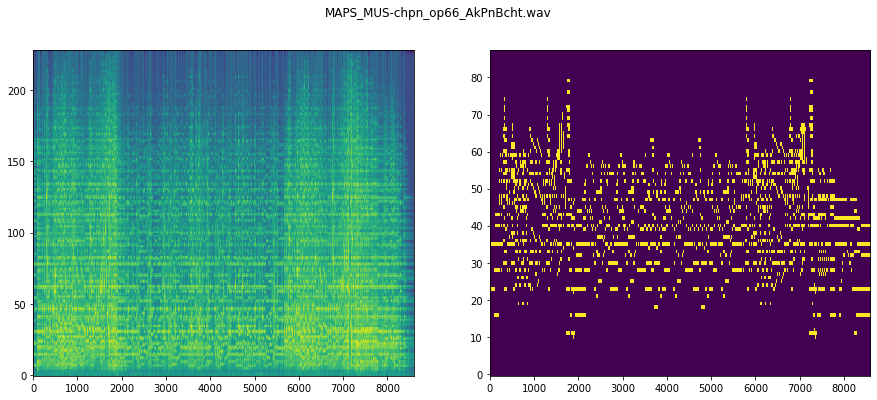

In [4]:
# to_plot = np.random.choice(len(x_list), 10)
# for i in to_plot:
#     fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)    
#     ax = axes[0]
#     ax.imshow(x_list[i].T, aspect='auto')
#     ax.invert_yaxis()
    
#     ax = axes[1]
#     ax.imshow(y_list[i].T, aspect='auto')
#     ax.invert_yaxis()

#     plt.suptitle(na_list[i])
#     plt.show()
    
filename = 'MAPS_MUS-chpn_op66_AkPnBcht'
idx = [i for i, file in enumerate(na_list) if filename in file]
assert len(idx) == 1
idx = idx[0]
    
fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)    
ax = axes[0]
ax.imshow(x_list[idx].T, aspect='auto')
ax.invert_yaxis()

ax = axes[1]
ax.imshow(y_list[idx].T, aspect='auto')
ax.invert_yaxis()

plt.suptitle(na_list[idx])
plt.show()

In [3]:
config_acoustic = {
    'input_size': 229 * n_channels,
    'hidden_size': 512,
    'n_layers': 4,
    'output_size': 88,
    'activation': 'ReLU',
    'p': 0.25,
    'batch_size': 1000,
    'lr': 0.01,
}

config_language = {
    'input_size': 88,
    'hidden_size': 128,
    'n_layers': 2,
    'output_size': 88,
    'batch_size': 100,
    'lr': 0.01,
}

mgr = TrainMgr(config_acoustic, config_language, save_every=1)

In [4]:
# mgr.train_acoustic(dataset_train, 20)
model = mgr.acoustic_model
model.load_state_dict(torch.load('acoustic_model_10.pt'))
mgr.acoustic_model = model

# mgr.train_language(y_list_train_torch, 5)
language_model = mgr.language_model
language_model.load_state_dict(torch.load('flat_acoustic_language/language_model_20_bk.pt'))
mgr.language_model = language_model

In [6]:
thres = 0.01

In [5]:
sample_rate = 4000
n_step = 512
step_sec = float(n_step) / sample_rate

In [7]:
def save_midi(filename, threshold):
    idx = [i for i, file in enumerate(na_list) if filename in file]
    assert len(idx) == 1
    idx = idx[0]
    
    mid_roll = prob_to_midi_roll(y_list[idx][:500], 0.5)
    out_path = 'MIDI/{:s}.mid'.format(filename)
    write_midi_roll_to_midi(mid_roll, out_path)
    
    x, y = make_multi_channel([x_list[idx]], [y_list[idx]], n_channels)
    for i in range(n_channels):
        x[:, i, :] = scaler.transform(x[:, i, :])
    
    y_pred = greedy_decoding(x, mgr.acoustic_model, mgr.language_model)[:500] 
    
    mid_roll = prob_to_midi_roll(y_pred, threshold)
    out_path = 'MIDI/{:s}.mid'.format('{}_pred_stacked'.format(filename))
    write_midi_roll_to_midi(mid_roll, out_path)

In [9]:
# filename = 'MAPS_MUS-chpn_op66_AkPnBcht'
# filename = 'MAPS_MUS-bach_850_AkPnB3sdf'
filename = 'MAPS_MUS-chpn-p10_AkPnStgb'
save_midi(filename, thres)

In [27]:
# !timidity MAPS_MUS-chpn_op66_AkPnBcht.mid
# !timidity MAPS_MUS-chpn_op66_AkPnBcht_pred.mid

In [18]:
dataset_test = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
loader = DataLoader(dataset_test, batch_size=int(2e4), shuffle=False)
acc, fvalue = batch_metrics_greedy_decoding(
    loader, 
    mgr.acoustic_model, 
    mgr.language_model, 
    thres=thres, 
    average='micro'
)

print('Accuracy: {:.2%}'.format(acc))
print('F score: {:.2%}'.format(fvalue))

100%|██████████| 15/15 [05:46<00:00, 23.09s/it]


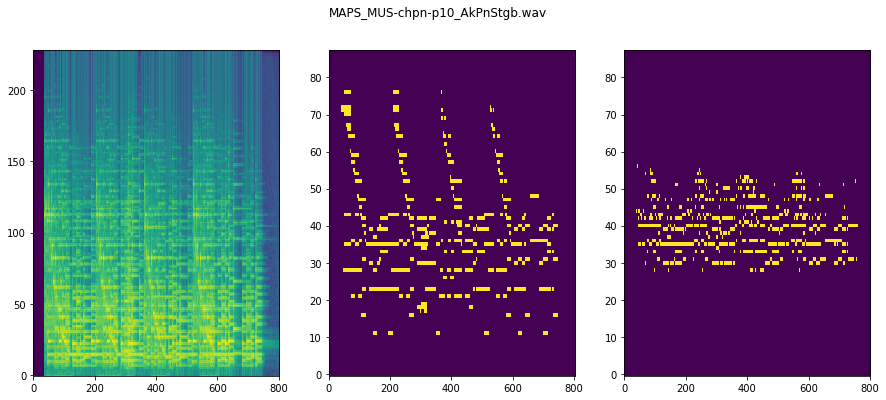

In [16]:
mgr.acoustic_model.eval()

# to_plot = np.random.choice(len(x_list), 3)
# for idx in to_plot:
#     fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)    
#     ax = axes[0]
#     ax.imshow(x_list[idx].T, aspect='auto')
#     ax.invert_yaxis()
    
#     ax = axes[1]
#     ax.imshow(y_list[idx].T, aspect='auto')
#     ax.invert_yaxis()

#     x, _ = make_multi_channel([x_list[idx]], [y_list[idx]], n_channels)
#     for i in range(n_channels):
#         x[:, i, :] = scaler.transform(x[:, i, :])
    
#     x = torch.FloatTensor(x).contiguous()
    
#     y_pred = mgr.acoustic_model(x).data.cpu().numpy()
#     ax = axes[2]
#     ax.imshow((y_pred>0.5).T, aspect='auto')
#     ax.invert_yaxis()

#     plt.suptitle(na_list[idx])
#     plt.show()
    
    
filename = 'MAPS_MUS-chpn-p10_AkPnStgb'
idx = [i for i, file in enumerate(na_list) if filename in file]
assert len(idx) == 1
idx = idx[0]

fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)    
ax = axes[0]
ax.imshow(x_list[idx].T, aspect='auto')
ax.invert_yaxis()

ax = axes[1]
ax.imshow(y_list[idx].T, aspect='auto')
ax.invert_yaxis()

x, _ = make_multi_channel([x_list[idx]], [y_list[idx]], n_channels)
for i in range(n_channels):
    x[:, i, :] = scaler.transform(x[:, i, :])

x = torch.FloatTensor(x).contiguous()

y_pred = greedy_decoding(x, mgr.acoustic_model, mgr.language_model).data.cpu().numpy()

ax = axes[2]
ax.imshow((y_pred>0.07).T, aspect='auto')
ax.invert_yaxis()

plt.suptitle(na_list[idx])
plt.show()